In [ ]:
# initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from dotenv import load_dotenv
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator

# from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

maze = [1, 0, 1, 0]
# maze = [1, 0, 1, 1, 0, 1, 1, 0, 1]
# maze = [
#     [1, 0, 1, 1, 1, 1, 1, 1],
#     [1, 0, 0, 0, 0, 0, 0, 1],
#     [1, 1, 0, 1, 1, 0, 1, 1],
#     [1, 0, 1, 1, 1, 0, 1, 1],
#     [1, 0, 0, 0, 0, 0, 0, 1],
#     [1, 1, 1, 1, 0, 1, 1, 1],
#     [1, 0, 0, 0, 0, 0, 0, 1],
#     [1, 0, 1, 1, 1, 1, 1, 1],
# ]

In [ ]:
# Maze conversion
maze = np.array(maze)
maze = maze.flatten()

# Creating the maze circuit
n = 4
board_qubits = QuantumRegister(n, name="b")
var_qubits = QuantumRegister(n, name="v")
oracle = QuantumRegister(1, name="o")
auxiliary = QuantumRegister(n - 1, name="a")
cbits = ClassicalRegister(n, name="cbits")
qc = QuantumCircuit(board_qubits, var_qubits, oracle, auxiliary, cbits)

directions = [int(-math.sqrt(n)), 1, int(math.sqrt(n)), -1]
# UP  RIGHT  DOWN  LEFT

list_of_empty_squares = []

# Mark all 1s in the board
for square in range(n):
    if maze[square] == 1:
        qc.x(board_qubits[square])
    # If not a 1, add it to a list as an empty square that can be traversed
    else:
        list_of_empty_squares.append(square)

print(list_of_empty_squares)


# Create NOR Gate Oracle
def create_oracle(qc, n):
    # Connect all squares that are 0s and that are next to each other
    duplicate_list = []
    for q in range(n):
        for direction in directions:
            # Make sure index is actually in the list, also avoids wraparounds for negative list indices
            if 0 <= q + direction < len(maze):
                if maze[q] == 0 and maze[q + direction] == 0:
                    if (q, q) not in duplicate_list:
                        qc.cx(var_qubits[q], board_qubits[q])
                        duplicate_list.append((q, q))
                    else:
                        continue
                    if (q, q + direction) not in duplicate_list:
                        qc.cx(var_qubits[q + direction], board_qubits[q])
                        duplicate_list.append((q, q + direction))
                    else:
                        continue
    for q in range(n):
        qc.x(q)
    qc.mcx(
        board_qubits[list_of_empty_squares],
        oracle[0],
        auxiliary[list_of_empty_squares],
        mode="basic",
    )
    for q in range(n):
        qc.x(q)
    # Reverse cx gates

    for q in range(n):
        for direction in directions:
            # Make sure index is actually in the list, also avoids wraparounds for negative list indices
            if 0 <= q + direction < len(maze):
                if maze[q] == 0 and maze[q + direction] == 0:
                    if (q, q) not in duplicate_list:
                        qc.cx(var_qubits[q], board_qubits[q])
                        duplicate_list.append((q, q))
                    else:
                        continue
                    if (q, q + direction) not in duplicate_list:
                        qc.cx(var_qubits[q + direction], board_qubits[q])
                        duplicate_list.append((q, q + direction))
                    else:
                        continue


# Initialize Superposition
qc.h(var_qubits)
qc.x(oracle[0])
qc.h(oracle[0])
qc.barrier()

# Iteration of Grover
for i in range(3):
    create_oracle(qc, n)
    qc.barrier()
    # Diffuser
    qc.h(var_qubits[:])
    qc.x(var_qubits[:])
    qc.h(var_qubits[n - 1])
    qc.mcx(var_qubits[0 : n - 1], var_qubits[n - 1], auxiliary[0 : n - 2], mode="basic")
    qc.h(var_qubits[n - 1])
    qc.x(var_qubits[:])
    qc.h(var_qubits[:])
    qc.barrier()


# Uncompute
qc.h(oracle[0])
qc.x(oracle[0])

qc.measure(var_qubits, cbits)
qc.reverse_bits()

print(qc.draw())

[1, 4, 7]
         ┌───┐      ░ ┌───┐┌───┐                                              »
    b_0: ┤ X ├──────░─┤ X ├┤ X ├──────────────────────────────────────────────»
         └───┘      ░ ├───┤└───┘     ┌───┐┌───┐                          ┌───┐»
    b_1: ───────────░─┤ X ├──────────┤ X ├┤ X ├──────────────────────■───┤ X ├»
         ┌───┐      ░ └─┬─┘┌───┐┌───┐└─┬─┘└───┘                      │   └───┘»
    b_2: ┤ X ├──────░───┼──┤ X ├┤ X ├──┼─────────────────────────────┼────────»
         ├───┤      ░   │  ├───┤├───┤  │                             │        »
    b_3: ┤ X ├──────░───┼──┤ X ├┤ X ├──┼─────────────────────────────┼────────»
         └───┘      ░   │  └───┘└───┘  │       ┌───┐┌───┐┌───┐       │   ┌───┐»
    b_4: ───────────░───┼──────────────┼───────┤ X ├┤ X ├┤ X ├───────■───┤ X ├»
         ┌───┐      ░   │  ┌───┐┌───┐  │       └─┬─┘└─┬─┘└───┘       │   └───┘»
    b_5: ┤ X ├──────░───┼──┤ X ├┤ X ├──┼─────────┼────┼──────────────┼────────»
         ├───┤      ░   │  ├──

{'111001011': 3, '110001111': 9, '100111111': 4, '111000010': 10, '010011000': 3, '101000110': 3, '001111100': 5, '010111111': 5, '111110011': 7, '111111001': 8, '100110111': 12, '011111111': 5, '000010111': 6, '010010110': 8, '000101110': 7, '011000001': 5, '101111000': 6, '001001110': 13, '100100110': 7, '011100101': 9, '000011101': 6, '010111100': 5, '110101100': 9, '001011101': 4, '000001010': 10, '000000001': 7, '100010110': 11, '101100111': 18, '111001001': 13, '001011110': 12, '000010100': 7, '100000011': 6, '110111010': 7, '010010111': 9, '101010000': 8, '100010101': 9, '110000010': 13, '010000110': 12, '011100100': 9, '101100110': 12, '111110111': 9, '111101100': 11, '010111011': 8, '011111011': 12, '001111111': 10, '011000111': 7, '000010010': 6, '000101100': 9, '011100010': 13, '110111111': 2, '000110000': 8, '001110111': 6, '000110010': 11, '011011110': 13, '010110010': 19, '111001110': 6, '000101001': 10, '111100110': 7, '110101111': 11, '100100011': 3, '000010000': 10, '1

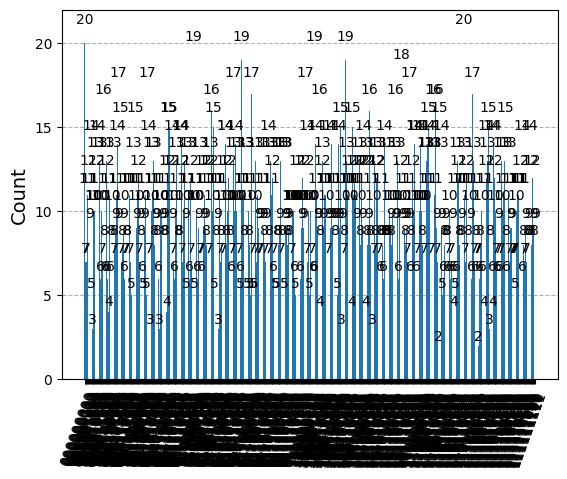

In [ ]:
# Simulate and plot result
backend = AerSimulator()
transpiled_qc = transpile(qc, backend=backend)
result = backend.run(transpiled_qc, shots=5000).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)